In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import itertools

In [10]:
test = pd.read_csv('/kaggle/input/test-dataset2/test_43.csv')

train = pd.read_csv('/kaggle/input/train-dataset2/train_43.csv')

In [11]:
train = train.drop_duplicates()
test = test.drop_duplicates()

train = train.reset_index()
test = test.reset_index()

pos_test = pd.DataFrame(test, columns=['x','y'])
label_test = pd.DataFrame(test, columns=["label"])

pos_train = pd.DataFrame(train, columns=['x','y'])
label_train = pd.DataFrame(train, columns=["label"])

data_test = pd.concat([pos_test, label_test], axis=1)
data_train = pd.concat([pos_train, label_train], axis=1)

In [12]:
class GNB:
    
    def __init__(self, X, y):
        no_samples, no_features = X.shape
        self.classes = np.unique(y)
        no_classes = len(self.classes)
        
        #initializing mean, variance and prior probabilities
        
        mean_sum0 = np.zeros(no_features, dtype = np.float64)
        covar_sum0 = np.zeros((no_classes, no_classes), dtype = np.float64)
        self.mean0 = np.zeros(no_features, dtype = np.float64)
        self.covar0 = np.ones((no_features, no_features), dtype = np.float64)
        
        self.prior = np.zeros(no_classes, dtype = np.float64)
        
        for i in range(len(X)):
            if int(y.values[i]) == 0:
                for j in range(2):
                    mean_sum0[j] += X.iloc[i][j]
        
        for j in range(2):
            self.mean0[j] = float(mean_sum0[j] / len(X))
            
        
        self.covar0[0,1] = 0
        self.covar0[1,0] = 0
            
        mean_sum1 = np.zeros(no_features, dtype = np.float64)
        covar_sum1 = np.zeros((no_classes, no_classes), dtype = np.float64)
        self.mean1 = np.zeros(no_features, dtype = np.float64)
        self.covar1 = np.ones((no_features, no_features), dtype = np.float64)
        
        for i in range(len(X)):
            if int(y.values[i]) == 1:
                for j in range(2):
                    mean_sum1[j] += X.iloc[i][j]
        
        for j in range(2):
            self.mean1[j] = float(mean_sum1[j] / len(X))
            
        self.covar1[0,1] = 0
        self.covar1[1,0] = 0
        
            
        mean_sum2 = np.zeros(no_features, dtype = np.float64)
        covar_sum2 = np.zeros((no_classes, no_classes), dtype = np.float64)
        self.mean2 = np.zeros(no_features, dtype = np.float64)
        self.covar2 = np.ones((no_features, no_features), dtype = np.float64)
        
        for i in range(len(X)):
            if int(y.values[i]) == 2:
                for j in range(2):
                    mean_sum2[j] += X.iloc[i][j]
        
        for j in range(2):
            self.mean2[j] = float(mean_sum2[j] / len(X))
            
        self.covar2[0,1] = 0
        self.covar2[1,0] = 0
        
        label_count = [0, 0, 0]
        
        for i in range(len(X)):
            if int(y.values[i]) == 0:
                label_count[0] +=1
            elif int(y.values[i]) == 1:
                label_count[1] +=1
            else:
                label_count[2] +=1
        
        for c in self.classes:
                self.prior[c] = float(label_count[c]/len(X))
            
    def predict(self, X):
        y_pred = []
        for x in range(len(X)):
            y_pred.append(self._predict(X.iloc[x]))
        
        return y_pred
            
    def _predict(self, X):
        posteriors = []
        
        for c_indx in self.classes:
            
            prior = np.log(self.prior[c_indx])
            class_conditional = np.sum(np.log(self.pdf(c_indx, X)))

            posterior = prior + class_conditional
            posteriors.append(posterior)
            
        return self.classes[np.argmax(posteriors)]
                
    def pdf(self, class_idx, x):
        if class_idx == 0:
            mean = self.mean0
            mean_tsp = self.mean0.transpose()
            covar = self.covar0
            covar_inv = np.linalg.inv(self.covar0)
            covar_det = self.covar0[0,0]*self.covar0[1,1]

            numerator = float(np.exp(-np.dot(np.dot(np.subtract(x, mean),covar_inv),np.subtract(x.transpose(),mean_tsp))/2))
            denominator = 2 * np.pi * np.sqrt(covar_det) 
            return numerator / denominator
        
        elif class_idx == 1:
            mean = self.mean1
            mean_tsp = self.mean1.transpose()
            covar = self.covar1
            covar_inv = np.linalg.inv(self.covar1)
            covar_det = self.covar1[0,0]*self.covar1[1,1]

            numerator = float(np.exp(-np.dot(np.dot(np.subtract(x, mean),covar_inv),np.subtract(x.transpose(),mean_tsp))/2))
            denominator = 2 * np.pi * np.sqrt(covar_det) 
            return numerator / denominator
        
        elif class_idx == 2:
            mean = self.mean2
            mean_tsp = self.mean2.transpose()
            covar = self.covar2
            covar_inv = np.linalg.inv(self.covar2)
            covar_det = self.covar2[0,0]*self.covar2[1,1]

            numerator = float(np.exp(-np.dot(np.dot(np.subtract(x, mean),covar_inv),np.subtract(x.transpose(),mean_tsp))/2))
            denominator = 2 * np.pi * np.sqrt(covar_det) 
            return numerator / denominator
        
    def predict_boundary(self,X):
        y_pred = []
        for x in range(len(X)):
            y_pred.append(self._predict_boundary(X[x]))
        
        return y_pred
    
    def _predict_boundary(self, X):
        posteriors = []
        
        for c_indx in self.classes:
            
            prior = np.log(self.prior[c_indx])
            class_conditional = np.sum(np.log(self.pdf(c_indx, X)))

            posterior = prior + class_conditional
            posteriors.append(posterior)
            
        if self.classes[np.argmax(posteriors)] == 0:
            return "predicted_0"
        elif self.classes[np.argmax(posteriors)] == 1:
            return "predicted_1"
        else:
            return "predicted_2"

In [13]:
prediction = GNB(pos_train, label_train)

pred_test = prediction.predict(pos_test)
pred_train = prediction.predict(pos_train)

correct=0

for i in range(len(pred_test)):
    if pred_test[i] == int(label_test.values[i]):
        correct+=1
        
print(f"Accuracy on test data is {correct/len(pred_test)*100}%")

correct = 0 

for i in range(len(pred_train)):
    if pred_train[i] == int(label_train.values[i]):
        correct+=1
        
print(f"Accuracy of train data is {correct/len(pred_train)*100}%")

Accuracy on test data is 100.0%
Accuracy of train data is 99.8%


The plot of classification boundary with test data is as follows:


<AxesSubplot:xlabel='x', ylabel='y'>

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


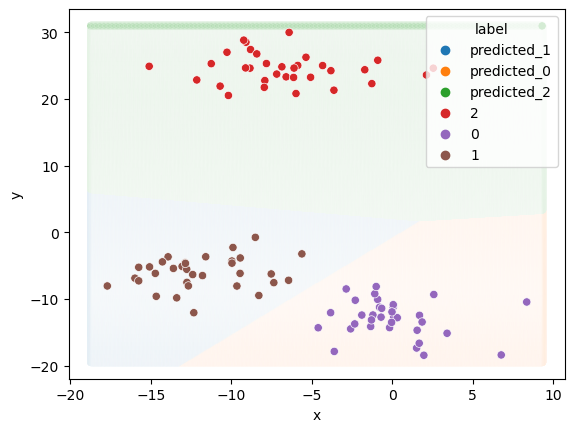

In [14]:
min_x, max_x = pos_test.iloc[:, 0].min()-1, pos_test.iloc[:, 0].max()+1
min_y, max_y = pos_test.iloc[:, 1].min()-1, pos_test.iloc[:, 1].max()+1

#creating a grid to draw a decision boundary

xgrid = np.arange(min_x, max_x, 0.05)
ygrid = np.arange(min_y, max_y, 0.05)

# create all of the lines and rows of the grid

xx, yy = np.meshgrid(xgrid, ygrid)

# flatten each grid to a vector

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x,y input for the model

grid = np.hstack((r1,r2))

model = GNB(pos_train, label_train)
boundary = model.predict_boundary(grid)

boundary = pd.DataFrame(boundary, columns=["label"])
boundary_pos = pd.DataFrame(grid, columns=["x","y"])

boundary = boundary_pos.join(boundary)
boundary = boundary.append(test)

print("The plot of classification boundary with test data is as follows:")

sns.scatterplot(x="x", y="y", hue='label', data=boundary)

Confusion matrix for test data is as follows:


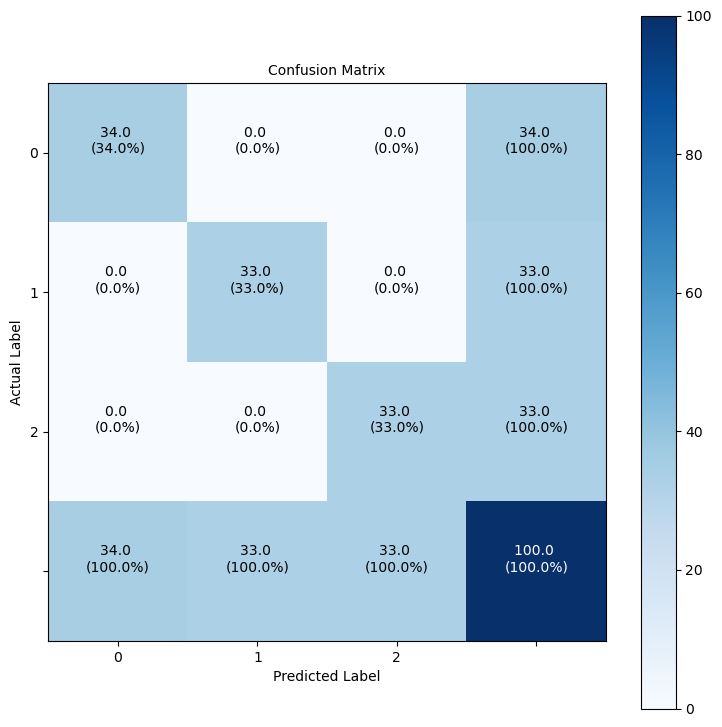

In [15]:
predicted = pd.DataFrame(pred_test, columns = ["label"])
actual = label_test

def confusion_matrix(actual, predicted):
    
    # extract the different classes
    no_classes = np.unique(actual)

    # initialize the confusion matrix
    confusion_matx = np.zeros((len(no_classes)+1, len(no_classes)+1))

    for a in range(len(actual)):
        confusion_matx[actual.iloc[a], predicted.iloc[a]] +=1
    
    return confusion_matx


# Updating the function we made above

def plot_confusion_matrix(actual , predicted , classes = None , text_size = 10, figsize = (9 , 9)):

    # Setting the default figsize 
    
    figsize = figsize
    
    # Create the confusion matrix
    
    cm = confusion_matrix(actual, predicted)
    
    for i in range(len(cm[0])-1):
        for j in range(len(cm[0])-1):
            cm[i,len(cm[0])-1] += cm[i,j]
            
    for i in range(len(cm[0])-1):
        for j in range(len(cm[0])-1):
            cm[len(cm[0])-1,i] += cm[j,i]
    
    for i in range(len(cm[0])-1):
        for j in range(len(cm[0])-1):
            cm[len(cm[0])-1,len(cm[0])-1] += cm[i,j]
    
    cm_norm = cm.astype('float') / len(actual)
    
    cm_norm[len(cm[0])-1,len(cm[0])-1] = 0
    
    for i in range(len(cm[0])-1):
        for j in range(len(cm[0])-1):
            cm_norm[i,len(cm[0])-1] = cm[i,i]/cm[i,len(cm[0])-1]
    
    for i in range(len(cm[0])-1):
        for j in range(len(cm[0])-1):
            cm_norm[len(cm[0])-1,j] = cm[j,j]/cm[len(cm[0])-1,j]
    
    for i in range(len(cm[0])-1):
        cm_norm[len(cm[0])-1,len(cm[0])-1] += cm[i,i]/len(actual)
        
    # Number of clases
    
    no_class = cm.shape[0]

    # Making our plot
    
    figure , conf_plt = plt.subplots(figsize = figsize)
    
    # Drawing the matrix plot 
    
    dr_conf = conf_plt.matshow(cm , cmap = plt.cm.Blues)
    figure.colorbar(dr_conf)

    # Setting labels
    
    if classes:
        labels = classes
    else:
        labels = [0, 1, 2,""]

    # Labeling axes
    
    conf_plt.set(title ='Confusion Matrix' , 
        xlabel = 'Predicted Label' , 
        ylabel = 'Actual Label' , 
        xticks = np.arange(no_class) , 
        yticks = np.arange(no_class) , 
        xticklabels = labels , 
        yticklabels = labels
        )
    
    # Setting the x axis labels
    
    conf_plt.xaxis.set_label_position('bottom')
    conf_plt.xaxis.tick_bottom()

    # Adjusting the size of labels
    conf_plt.title.set_size(text_size)
    conf_plt.xaxis.label.set_size(text_size)
    conf_plt.yaxis.label.set_size(text_size)

    # Setting threshold for colors 

    threshold = (cm.max() + cm.min()) / 2
    
    # Plot the text
    
    for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
        plt.text(j , i , f'{cm[i , j]} \n({cm_norm[i , j]*100:.1f}%)' , 
            horizontalalignment = 'center' , 
            color = 'white' if cm[i , j] > threshold else 'black' , 
                size = text_size)

np.seterr(divide='ignore', invalid='ignore')

print("Confusion matrix for test data is as follows:")

plot_confusion_matrix(actual, predicted)

Confusion Matrix for train data is as follows:


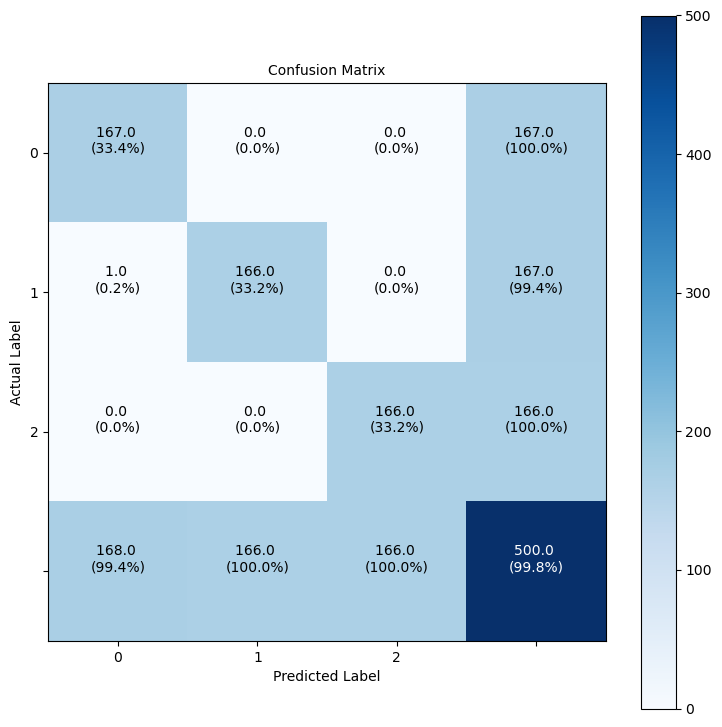

In [16]:
predicted = pd.DataFrame(pred_train, columns = ["label"])
actual = label_train

np.seterr(divide='ignore', invalid='ignore')

print("Confusion Matrix for train data is as follows:")

plot_confusion_matrix(actual, predicted)